### Random Forest Modeling for Bunning 2019 Human aging dataset



#### Step 1: Data preprocessing. 
We will combind the categorical data in sheet 2 into the numercial data and use them together for regression modeling

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

First, import the transformed data and contrapose it.

In [2]:
df = pd.read_excel("../transformed_data.xlsx", sheet_name=0, index_col=0)
df = df.T
print(df)

Metabolite name  L-Alanine  L-Aspartic acid  L-Asparagine  \
P1               -1.846172         0.484126      0.021412   
P2               -0.443329        -0.877494     -0.061673   
P3               -0.134794         0.206897      0.104678   
P4                1.068429        -0.146876     -0.031757   
P5                0.459775         0.530521      0.103970   
...                    ...              ...           ...   
P264             -1.348079         0.226587      0.110009   
P265             -0.694988         0.232135      0.170186   
P266             -1.474038         0.165482      0.056151   
P267             -1.353003         0.642928     -0.023424   
P268             -0.916607        -0.639974      0.368144   

Metabolite name  Glucosamine|Galactosamine  Hydroxyhippurate  L-Carnitine  \
P1                                0.861255         -0.173662     1.018054   
P2                                0.264052         -0.454759    -3.766291   
P3                                0.

Concatenate the categorical data from sheet 2 into the dataframe.

In [7]:
table2df = pd.read_excel("../acel13073-sup-0002-tables1-s3.xlsx", sheet_name=1, header=[0,1])
table2df.head()

Demographics                                            \
         Group Participant ID Pair ID Age     Sex    BMI   
0   >=16 years             P1      F1  27    Male  21.64   
1   >=16 years             P2      F2  33  Female  22.75   
2   >=16 years             P3      F2  34  Female  22.97   
3   >=16 years             P4      F3  35  Female  28.73   
4   >=16 years             P5      F3  35  Female  31.01   

                                                   \
                Ethnicity     Zygosity GINA score   
0  Non-Hispanic or Latino    Dizygotic          1   
1      Hispanic or Latino  Monozygotic          0   
2      Hispanic or Latino  Monozygotic          0   
3  Non-Hispanic or Latino  Monozygotic          0   
4  Non-Hispanic or Latino  Monozygotic          0   

                                 ... Self-reported medication classes  \
  Second-hand smoking exposure   ...               Thyroid supplement   
0                             1  ...                                0   
1                             1  ...                                0   
2                             0  ...                                0   
3                             0  ...                                0   
4                             0  ...                                0   

                                                                          \
  Inhaled corticosteroids Aspirin Anti-diabetes ACE Leukotrene inhibitor   
0                       0       0             0   0                    0   
1                       0       0             0   0                    0   
2                       0       0             0   0                    0   
3                       0       0             0   0                    0   
4                       0       0             0   0                    0   

                                                                     \
  Proton Pump Inhibitor (PPI) Hormone replacement Urinary retention   
0                           0                   0                 0   
1                           0                   0                 0   
2                           0                   0                 0   
3                           0                   0                 0   
4                           0                   0                 0   

               
  Nerve block  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 34 columns]

In [9]:
df['Sex'] = table2df['Demographics']['Sex'].values
# One-hot encode the Sex and scale BMI so that id doesn't become a dominant feature
# df = pd.get_dummies(df, columns=['Sex'])
df['Sex'] = df['Sex'].map(lambda x: 1 if x == 'Male' else 0)

df['BMI'] = table2df['Demographics']['BMI'].values
# df['BMI'] = StandardScaler().fit_transform(df[['BMI']])


# Age always needs to be at the end since it's the label
df['Age'] = table2df['Demographics']['Age'].values
df.head()

Metabolite name,L-Alanine,L-Aspartic acid,L-Asparagine,Glucosamine|Galactosamine,Hydroxyhippurate,L-Carnitine,Ectoine,Corticosterone,Creatinine,Creatine,...,C8H12N2O5,C9H16N2O4,C9H16O4,C9H18O9,C9H9NO4,C5H8O6,C12H16O6,Sex,BMI,Age
P1,-1.846172,0.484126,0.021412,0.861255,-0.173662,1.018054,-0.047993,-0.678022,0.590303,-1.261375,...,0.642057,0.587633,0.379383,-0.084655,0.751380,-0.229849,-0.119829,1,21.64,27
P2,-0.443329,-0.877494,-0.061673,0.264052,-0.454759,-3.766291,1.083980,-0.221590,-0.329841,-0.501870,...,0.203458,2.074760,-1.527215,-0.088695,0.641425,0.682707,-1.204619,0,22.75,33
P3,-0.134794,0.206897,0.104678,0.283471,-0.607615,0.736472,-0.409403,0.810842,0.119172,0.405288,...,0.233128,-0.047189,1.119094,0.221023,0.700568,0.810287,-0.582386,0,22.97,34
P4,1.068429,-0.146876,-0.031757,0.368148,0.922386,1.818349,0.683843,1.115335,0.941316,1.794518,...,0.437994,0.567404,0.873934,0.164568,1.194226,-0.240203,1.818600,0,28.73,35
P5,0.459775,0.530521,0.103970,0.355795,-0.386900,1.087127,1.320936,0.888927,0.675092,0.413189,...,0.162881,0.474926,-0.670962,0.207942,0.522442,0.003037,0.176705,0,31.01,35


Perform a random forest prediction on this dataframe

In [10]:
# df.to_csv("concactenated sex and bmi.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
# print(X)
# print(y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# pca = PCA(n_components=50)  # reduce to 50 components, for example

rf = RandomForestRegressor(n_estimators=200, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)


mse_scores=[]
all_predictions = []
all_true = []
total_importances = np.zeros(X.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # # Dimensionality reduction on training data
    # X_train_pca = pca.fit_transform(X_train)
    X_train_pca = X_train
    
    # # Apply transformation to validation data
    # X_val_pca = pca.transform(X_val)
    X_val_pca = X_val

    # Train the random forest model
    rf.fit(X_train_pca, y_train)

    # Predict on validation set
    y_pred = rf.predict(X_val_pca)

    # Calculate the mean squared error and store it
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)
    all_predictions.extend(y_pred)
    all_true.extend(y_val)

    total_importances += rf.feature_importances_

# Calculate average MSE across folds
avg_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error: {avg_mse}")

Visualization:

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mse_scores contains the Mean Squared Errors from previous steps

# 1. Bar plot for errors across folds
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, len(mse_scores) + 1)), y=mse_scores)
plt.xlabel('Fold Number')
plt.ylabel('Mean Squared Error')
plt.title('MSE Across Folds')
plt.show()

# If you have predictions from a particular fold or a concatenated list of all folds:
# 2. Actual vs. Predicted plot
y_true = np.array(all_true)  # Actual values (fill this in)
y_pred = np.array(all_predictions)  # Predicted values from the model (fill this in)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

# Feature importance chart
# Get average feature importance
avg_importances = total_importances / kf.get_n_splits()
indices = np.argsort(avg_importances)[::-1]  # Sort in descending order

# Convert the importances into a DataFrame for easier handling
print(len(df.iloc[:,:-1]), len(avg_importances))
feature_importances = pd.DataFrame({"feature": list(df.iloc[:,:-1].columns), "importance": avg_importances})

# Sort the DataFrame to make the plot clearer
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Limit the DataFrame to the top 20 features
top_20_features = feature_importances.head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=top_20_features, x='importance', y='feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()  # Ensures that everything fits well in the plot
plt.show()

NameError: name 'mse_scores' is not defined

<Figure size 1000x600 with 0 Axes>

Adjust the metabolite features based on the BMI and sex.

In [13]:
from sklearn.linear_model import LinearRegression

X = df[["Sex", "BMI"]]

for i in range(0, 770):
    y = df.iloc[:,i]
    model = LinearRegression().fit(X, y)
    df.iloc[:, i] = y - model.predict(X)

print(df.iloc[:, 770])
df.head()

P1      1
P2      0
P3      0
P4      0
P5      0
       ..
P264    0
P265    0
P266    0
P267    0
P268    0
Name: Sex, Length: 268, dtype: int64


Metabolite name,L-Alanine,L-Aspartic acid,L-Asparagine,Glucosamine|Galactosamine,Hydroxyhippurate,L-Carnitine,Ectoine,Corticosterone,Creatinine,Creatine,...,C8H12N2O5,C9H16N2O4,C9H16O4,C9H18O9,C9H9NO4,C5H8O6,C12H16O6,Sex,BMI,Age
P1,-1.870348,0.325436,-0.093506,1.043223,0.046746,0.744444,-0.197559,-0.733739,0.505004,-1.145949,...,0.764096,0.588139,0.567625,0.125033,0.927934,-0.086406,-0.148025,1,21.64,27
P2,-0.343053,-0.768804,-0.003755,0.157708,-0.437031,-3.639361,1.206455,-0.070905,-0.012672,-0.624887,...,0.158896,2.157630,-1.601811,-0.185951,0.582638,0.486404,-1.157331,0,22.75,33
P3,-0.039500,0.314275,0.162833,0.177586,-0.597702,0.864595,-0.289309,0.954639,0.420856,0.285736,...,0.187346,0.030931,1.042951,0.122851,0.639690,0.620771,-0.536929,0,22.97,34
P4,1.033282,-0.073839,0.032628,0.274287,0.727701,1.977703,0.741607,1.078783,0.837556,1.765690,...,0.360254,0.521175,0.757261,0.042431,1.078620,-0.252024,1.816115,0,28.73,35
P5,0.372996,0.589965,0.170819,0.266694,-0.662572,1.258845,1.354029,0.780987,0.410845,0.420273,...,0.072491,0.379475,-0.803678,0.076320,0.385173,0.061554,0.155242,0,31.01,35


In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# drop all ages < 16

df = df[df['Age'] >= 16]


X = df.iloc[:, :770].values
y = df.iloc[:, -1].values
# print(X)
# print(y)

# pca = PCA(n_components=50)  # reduce to 50 components, for example

rf = RandomForestRegressor(n_estimators=100, random_state=5, bootstrap=True)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)


all_predictions = []
all_true = []
total_importances = np.zeros(770)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 5, test_size=0.2)

# # Dimensionality reduction on training data
# X_train_pca = pca.fit_transform(X_train)
X_train_pca = X_train

# # Apply transformation to validation data
# X_val_pca = pca.transform(X_val)
X_val_pca = X_val

# Train the random forest model
rf.fit(X_train_pca, y_train)

# Predict on validation set
y_pred = rf.predict(X_val_pca)

# Calculate the mean squared error and store it
test_mse = mean_squared_error(y_val, y_pred)
train_mse = mean_squared_error(y_train, rf.predict(X_train_pca))

all_predictions.extend(y_pred)
all_true.extend(y_val)

# # Adding validation set
all_predictions.extend(rf.predict(X_train_pca))
all_true.extend(y_train)

total_importances += rf.feature_importances_

# Calculate average MSE across folds
print(f"Train set MSE: {train_mse}")
print(f"Test set MSE: {test_mse}")

Train set MSE: 23.876518691588785
Test set MSE: 142.64273518518516


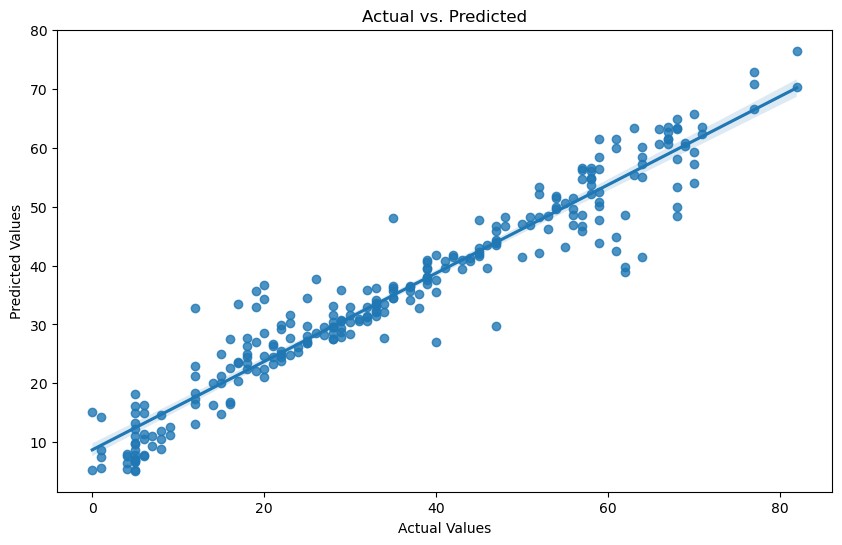

268 770


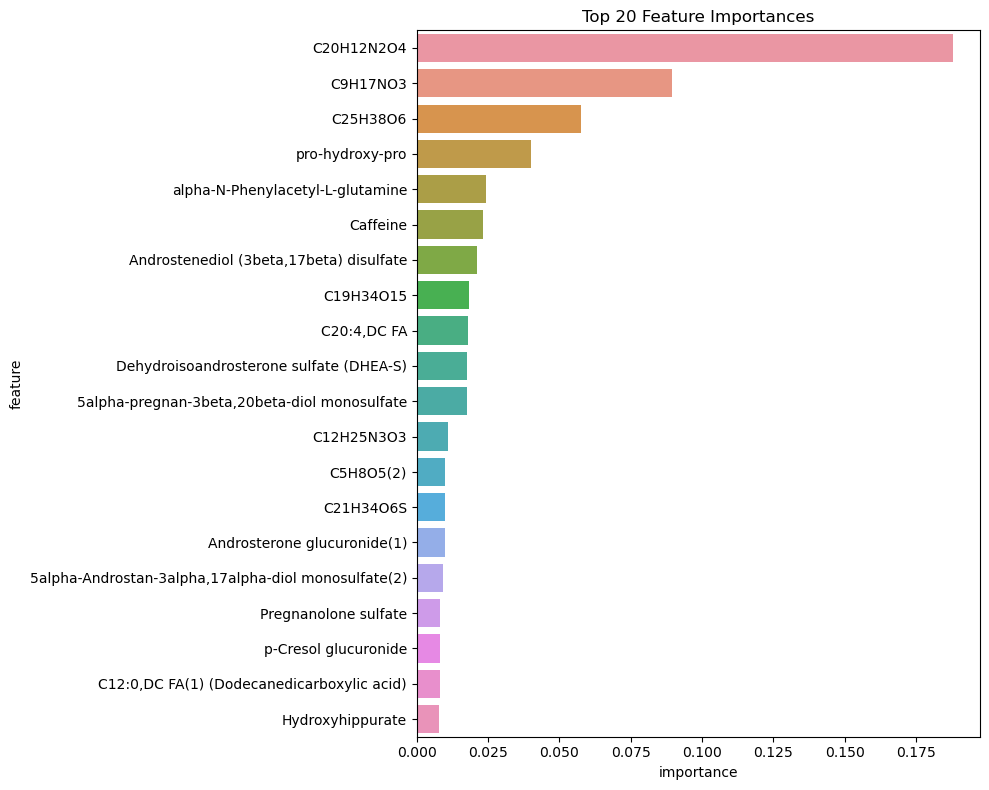

r2 score is 0.891973353858351
Total average Mse score is 47.62976199030806


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mse_scores contains the Mean Squared Errors from previous steps

# # 1. Bar plot for errors across folds
# plt.figure(figsize=(10, 3))
# sns.barplot(x=list(range(1, len(mse_scores) + 1)), y=mse_scores)
# plt.xlabel('Fold Number')
# plt.ylabel('Mean Squared Error')
# plt.title('MSE Across Folds')
# plt.show()

# If you have predictions from a particular fold or a concatenated list of all folds:
# 2. Actual vs. Predicted plot
y_true = np.array(all_true)  # Actual values (fill this in)
y_pred = np.array(all_predictions)  # Predicted values from the model (fill this in)

plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_true, y=y_pred)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='red')  # Diagonal line
sns.regplot(x= y_true, y = y_pred).set_title("Actual vs. Predicted Age")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

# Feature importance chart
# Get average feature importance
avg_importances = total_importances 
indices = np.argsort(avg_importances)[::-1]  # Sort in descending order

# Convert the importances into a DataFrame for easier handling
print(len(df.iloc[:,:770]), len(avg_importances))
feature_importances = pd.DataFrame({"feature": list(df.iloc[:,:770].columns), "importance": avg_importances})

# Sort the DataFrame to make the plot clearer
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Limit the DataFrame to the top 20 features
top_20_features = feature_importances.head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=top_20_features, x='importance', y='feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()  # Ensures that everything fits well in the plot
plt.show()

from sklearn.metrics import r2_score

r2 = r2_score(y, rf.predict(X))
print(f"r2 score is {r2}")
print(f"Total average Mse score is {train_mse * 0.8 + test_mse * 0.2}")

Plot the chart of Age vs. BMI

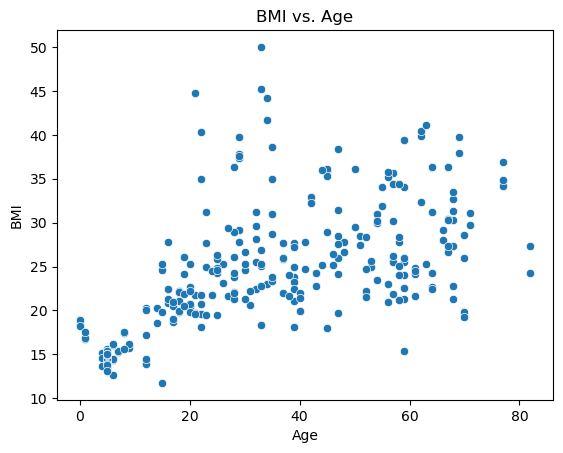

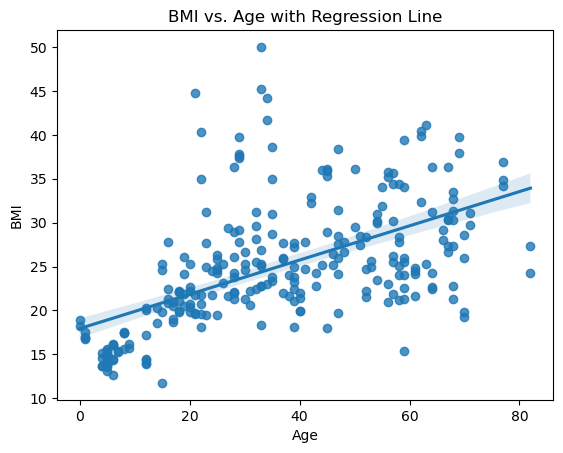

In [17]:
# Using Seaborn (this provides a bit more styling by default)
sns.scatterplot(data=df, x='Age', y='BMI').set_title('BMI vs. Age')
plt.show()
sns.regplot(data=df, x='Age', y='BMI').set_title('BMI vs. Age with Regression Line')
plt.show()
